# Classify 2D shapes

- SELU instead of RELU?
- weight initialisation?

In [190]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import os
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from tqdm import tqdm
from cnn_util import conv_dims, pool_dims

# from data_load import ShapeDimensionDataset
#import regression


In [191]:
data_dir = 'dataset'
BATCH_SIZE = 32

In [228]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(),
        transforms.RandomRotation(45, expand=True, fill=255),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(),
        transforms.RandomRotation(45, expand=True, fill=255),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),        
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=6)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [229]:
dlt = dataloaders['train']
dst = image_datasets['train']
dst.classes


['C2', 'I1', 'L2', 'OTHER', 'Z3', 'Z5', 'Z8', 'Z9']

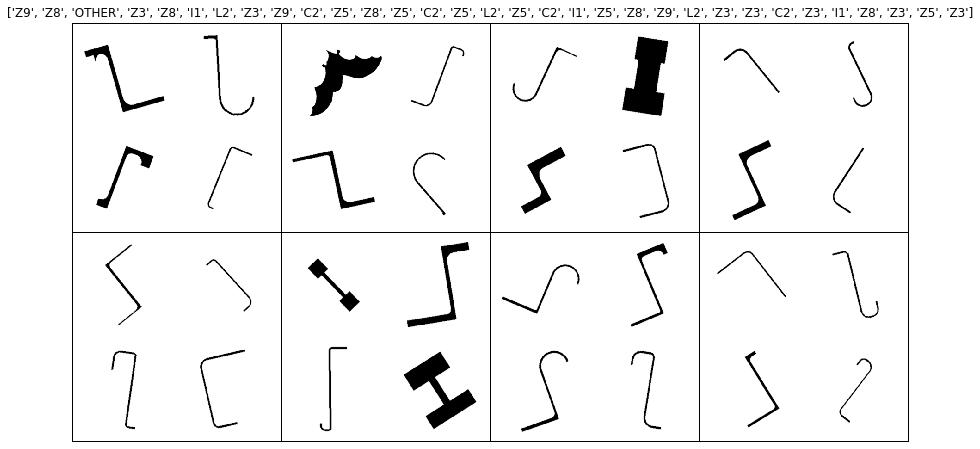

In [230]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    #inp = np.clip(inp, 0, 1)
    fig, ax = plt.subplots(figsize=(15,10))
    ax.imshow(inp, cmap="gray")
    if title is not None:
        ax.set_title(title)
    ax.set_axis_off()
    ax.grid(False)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes], )

In [231]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [232]:
num_classes = len(dst.classes)
model = ClfNet(num_classes)
model = model.to(device)

criterion = nn.NLLLoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [233]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=10)

  0%|          | 0/1401 [00:00<?, ?it/s]

Epoch 0/9
----------


  0%|          | 0/301 [00:00<?, ?it/s]

train Loss: 0.6389 Acc: 0.7420


  0%|          | 0/1401 [00:00<?, ?it/s]

val Loss: 0.3305 Acc: 0.8619

Epoch 1/9
----------


  0%|          | 0/301 [00:00<?, ?it/s]

train Loss: 0.2335 Acc: 0.9062


  0%|          | 0/1401 [00:00<?, ?it/s]

val Loss: 0.2131 Acc: 0.9113

Epoch 2/9
----------


  0%|          | 0/301 [00:00<?, ?it/s]

train Loss: 0.1582 Acc: 0.9366


  0%|          | 0/1401 [00:00<?, ?it/s]

val Loss: 0.1270 Acc: 0.9515

Epoch 3/9
----------


  0%|          | 0/301 [00:00<?, ?it/s]

train Loss: 0.1281 Acc: 0.9497


  0%|          | 0/1401 [00:00<?, ?it/s]

val Loss: 0.1246 Acc: 0.9499

Epoch 4/9
----------


  0%|          | 0/301 [00:00<?, ?it/s]

train Loss: 0.1106 Acc: 0.9571


  0%|          | 0/1401 [00:00<?, ?it/s]

val Loss: 0.1023 Acc: 0.9606

Epoch 5/9
----------


  0%|          | 0/301 [00:00<?, ?it/s]

train Loss: 0.0961 Acc: 0.9623


  0%|          | 0/1401 [00:00<?, ?it/s]

val Loss: 0.0834 Acc: 0.9680

Epoch 6/9
----------


  0%|          | 0/301 [00:00<?, ?it/s]

train Loss: 0.0830 Acc: 0.9680


  0%|          | 0/1401 [00:00<?, ?it/s]

val Loss: 0.0720 Acc: 0.9719

Epoch 7/9
----------


  0%|          | 0/301 [00:00<?, ?it/s]

train Loss: 0.0459 Acc: 0.9829


  0%|          | 0/1401 [00:00<?, ?it/s]

val Loss: 0.0363 Acc: 0.9873

Epoch 8/9
----------


  0%|          | 0/301 [00:00<?, ?it/s]

train Loss: 0.0357 Acc: 0.9866


  0%|          | 0/1401 [00:00<?, ?it/s]

val Loss: 0.0301 Acc: 0.9907

Epoch 9/9
----------


  0%|          | 0/301 [00:00<?, ?it/s]

train Loss: 0.0304 Acc: 0.9891


100%|██████████| 301/301 [00:15<00:00, 19.50it/s]

val Loss: 0.0251 Acc: 0.9914

Training complete in 54m 56s
Best val Acc: 0.991355


In [234]:
model.save_checkpoint("models/classifier2.pt")

In [235]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            logits = model(inputs)
            preds = logits.argmax(dim=1).numpy()    

            #fig = plt.Figure()
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}, true: {}'.format(class_names[preds[j]], class_names[labels[j]]))
                ax.imshow(inputs[j,0], cmap='gray')

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
    return fig

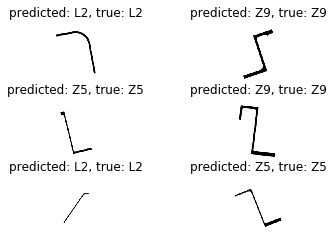

In [236]:
visualize_model(model)

## Evaluation
- Run prediction on all validation examples. 
- show misclassified items
- make confusion matrix

In [237]:
from PIL import Image

xfo = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize(224),
        transforms.ToTensor(),
    ])

def predict(model, fpath, classnames):
    """run model on a file, return class label"""
    img = Image.open(fpath)
    inp = xfo(img)
    inp = inp.expand((1,) + inp.shape) # because it's just one image
    with torch.no_grad():
        logits = model(inp)
        icls = logits.argmax().numpy()
    return classnames[icls]

In [238]:
import glob
import pandas as pd

filenames = glob.glob("dataset/test/*/*.png")
true_labels = [fname.split("/")[2] for fname in filenames]

In [239]:
class_names = np.array(image_datasets['train'].classes)
predicted_labels = [predict(model, fn, class_names) for fn in filenames]

In [240]:
df_eval = pd.DataFrame({'fname': filenames, 'true': true_labels, 'pred': predicted_labels})
df_eval.query("true != pred")

,fname,true,pred
569,dataset/test/Z8/1776.png,Z8,OTHER
725,dataset/test/Z8/6180.png,Z8,Z3
1243,dataset/test/Z8/623.png,Z8,Z9
1259,dataset/test/Z8/5661.png,Z8,Z9
1386,dataset/test/Z8/4776.png,Z8,Z3
...,...,...,...
9183,dataset/test/I1/5382.png,I1,OTHER
9196,dataset/test/I1/4795.png,I1,OTHER
9335,dataset/test/I1/4009.png,I1,OTHER
9336,dataset/test/I1/1305.png,I1,OTHER


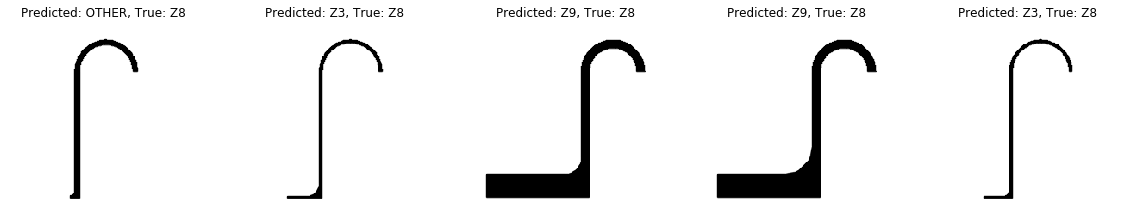

In [243]:
import cv2
misclassified = df_eval.query("true != pred")
misclassified = misclassified[]
n_mc = len(misclassified)

fig, axes = plt.subplots(1, n_mc, figsize=(20,10))
for i, t in enumerate(misclassified.itertuples()):
    img = cv2.imread(t.fname)
    axes[i].imshow(img)
    axes[i].set_title('Predicted: {}, True: {}'.format(t.pred, t.true))
    axes[i].set_axis_off()

In [242]:
len(true_labels)

9384